In [1]:
from model import *
from dataset import *

device = 'cuda:1'

In [2]:
model = Model(50)
model.load_state_dict(torch.load('./result/best.pt'))
model.to(device)
model.eval();

In [7]:
import torchvision.transforms

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

dataset = p1_Dataset('../hw2_data/p1_data/val_50/', transform)
dataloader = DataLoader(dataset,
                       batch_size=128,
                       shuffle=False,
                       num_workers=8)

@torch.no_grad()
def get_latent():
    X,y = [],[]
    
    for idx,(images, labels) in enumerate(dataloader):
        b = images.size(0)

        images, labels = images.to(device), labels.to(device)

        h = model.features(images)
        h = model.fc[0](h.view(b,-1))

        latent = h.reshape(b,-1)
        latent = latent.detach().cpu()

        X += latent.numpy().tolist()
        y += labels.cpu().numpy().tolist()
        
    return X,y

X, y = get_latent()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import manifold, datasets

# X = np.random.rand(128,512)
# y = np.array([i for i in range(4) for j in range(32)])
X = np.array(X)
y = np.array(y)

'''t-SNE'''
tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(X)

# normalize
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

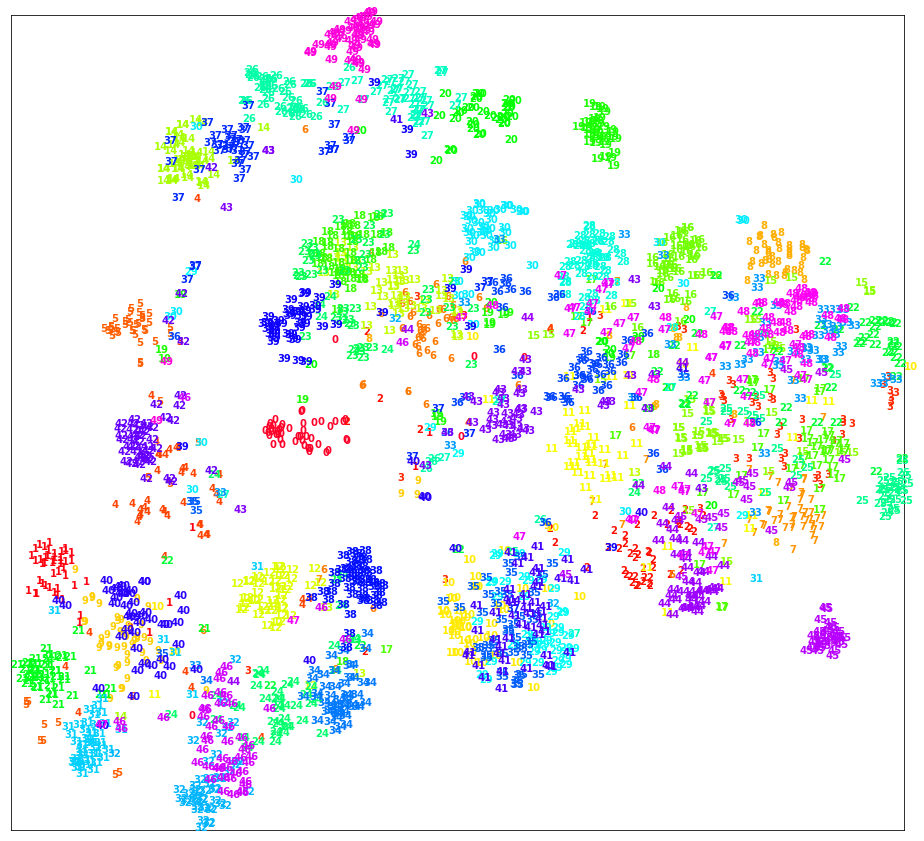

In [12]:
# show
NUM_CLASS=50
cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/NUM_CLASS) for i in range(NUM_CLASS)]

plt.figure(figsize=(16,15))
for i in range(X_norm.shape[0]):
    if y[i]<NUM_CLASS:
        plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=colors[y[i]], 
                 fontdict={'weight': 'bold', 'size': 10})
#     plt.text(X_norm[i, 0], X_norm[i, 1], str(y[i]), color=colors[y[i]], 
#              fontdict={'size': 8})
plt.xticks([])
plt.yticks([])
plt.show()